In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [112]:
expected_queries_results_file = "../results/expected_queries_results.csv"
queries_results_file = "../results/resultados.csv"
evaluations_dir = "../avalia/"
df_expected_queries_results = pd.read_csv(expected_queries_results_file, sep=';', index_col=0)
df_queries_results = pd.read_csv(queries_results_file, sep=';', index_col=0)

df_expected_queries_results

,DocNumber,DocVotes
QueryNumber,,
1,139,7
1,151,6
1,166,1
1,311,1
1,370,2
...,...,...
100,1000,6
100,1017,7
100,1033,1


In [113]:
df_queries_results

,Results
QueryNumber,
1,"[0, '00856', 0.35953811542195285]"
1,"[1, '00437', 0.3223062819205764]"
1,"[2, '00568', 0.31372398019421605]"
1,"[3, '00552', 0.3010918947924283]"
1,"[4, '00498', 0.29890869590426095]"
...,...
100,"[1210, '00974', 0.042130484149356495]"
100,"[1211, '01097', 0.039381426884307465]"
100,"[1212, '00558', 0.03767397976373646]"


In [114]:
def get_doc_number_from_result(result):
  result_list = result.strip("[]").replace("'", "").split(", ")
  doc_number = int(result_list[1])
  
  return doc_number

df_queries_results["DocNumber"] = df_queries_results["Results"].apply(get_doc_number_from_result)

df_queries_results

,Results,DocNumber
QueryNumber,,
1,"[0, '00856', 0.35953811542195285]",856
1,"[1, '00437', 0.3223062819205764]",437
1,"[2, '00568', 0.31372398019421605]",568
1,"[3, '00552', 0.3010918947924283]",552
1,"[4, '00498', 0.29890869590426095]",498
...,...,...
100,"[1210, '00974', 0.042130484149356495]",974
100,"[1211, '01097', 0.039381426884307465]",1097
100,"[1212, '00558', 0.03767397976373646]",558


In [115]:
expected_results_per_query = df_expected_queries_results.groupby("QueryNumber").apply(lambda x: x.values.tolist()).tolist()
results_per_query = df_queries_results.groupby("QueryNumber")["DocNumber"].apply(lambda x: x.tolist()).tolist()

print(f"Expected results len: {len(expected_results_per_query)}")
print(f"Results len: {len(results_per_query)}")

Expected results len: 99
Results len: 99


### Precision x Recall

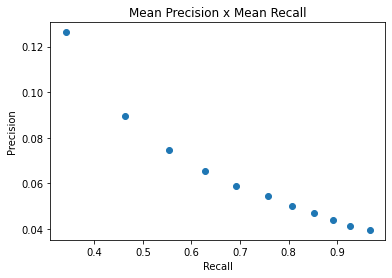

In [116]:
number_of_points = 11
mean_precisions = []
mean_recalls = []

for query_index in range(len(results_per_query)):
  query_relevant_documents = [result[0] for result in expected_results_per_query[query_index]]
  query_results = results_per_query[query_index]

  query_precisions = []
  query_recalls = []

  incremental_results_index = int(len(query_results)/number_of_points)

  for i in range(number_of_points):
    results_ranking = query_results[:(i+1)*incremental_results_index]

    tp = len(list(set(query_relevant_documents).intersection(results_ranking)))
    
    query_precisions.append(tp/len(results_ranking))
    query_recalls.append(tp/len(query_relevant_documents))

  mean_precisions.append(query_precisions)
  mean_recalls.append(query_recalls)

mean_precisions = np.mean(np.array(mean_precisions), axis=0)
mean_recalls = np.mean(np.array(mean_recalls), axis=0)

precision_recall_df = pd.DataFrame(np.array([mean_precisions, mean_recalls]).T, columns=["Precision", "Recall"])
precision_recall_df.to_csv(evaluations_dir + "11pontos-stemmer-1.csv", sep=";", index=False)

plt.scatter(mean_recalls, mean_precisions)
plt.title("Mean Precision x Mean Recall")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()


### F1

In [117]:
mean_precisions = []
mean_recalls = []

for query_index in range(len(results_per_query)):
  query_relevant_documents = [result[0] for result in expected_results_per_query[query_index]]
  query_results = results_per_query[query_index]

  results_ranking = query_results
  tp = len(list(set(query_relevant_documents).intersection(results_ranking)))
  
  query_precision = tp/len(results_ranking)
  query_recall = tp/len(query_relevant_documents)

  mean_precisions.append(query_precision)
  mean_recalls.append(query_recall)

mean_precisions = np.mean(np.array(mean_precisions))
mean_recalls = np.mean(np.array(mean_recalls))

F1 = (2 * mean_precisions * mean_recalls)/(mean_precisions + mean_recalls)

print(f"F1: {round(F1*100, 2)}%")


F1: 7.6%


### Precision @ k

In [118]:
def mean_precision_at_k(k, results_per_query, expected_results_per_query):
  mean_precisions = []

  for query_index in range(len(results_per_query)):
    query_relevant_documents = [result[0] for result in expected_results_per_query[query_index]]
    query_results = results_per_query[query_index]

    results_ranking = query_results[:k]
    tp = len(list(set(query_relevant_documents).intersection(results_ranking)))
    
    query_precision = tp/len(results_ranking)

    mean_precisions.append(query_precision)

  mean_precisions = np.mean(np.array(mean_precisions))

  return mean_precisions

mean_precision_at_5 = mean_precision_at_k(5, results_per_query, expected_results_per_query)
mean_precision_at_10 = mean_precision_at_k(10, results_per_query, expected_results_per_query)

print(f"Mean Precision@5: {round(mean_precision_at_5 * 100, 2)}%")
print(f"Mean Precision@10: {round(mean_precision_at_10 * 100, 2)}%")

Mean Precision@5: 41.01%
Mean Precision@10: 32.32%


### R-Precision

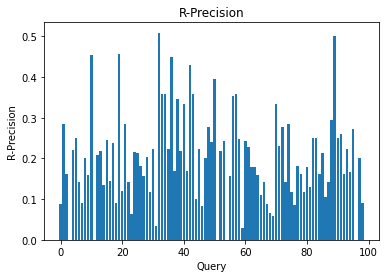

In [119]:
def r_precisions(results_per_query, expected_results_per_query):
  r_precisions = []

  for query_index in range(len(results_per_query)):
    query_relevant_documents = [result[0] for result in expected_results_per_query[query_index]]
    query_results = results_per_query[query_index]

    #Similar to precision@k. But in R-Precision k is the total relevant documents for the query.
    k = len(query_relevant_documents)
    results_ranking = query_results[:k]
    tp = len(list(set(query_relevant_documents).intersection(results_ranking)))
    
    query_precision = tp/len(results_ranking)

    r_precisions.append(query_precision)

  return r_precisions

r_precisions = r_precisions(results_per_query, expected_results_per_query)

r_precisions_df = pd.DataFrame(np.array([range(len(r_precisions)), r_precisions]).T, columns=["QueryIndex", "R-Precision"])
r_precisions_df.to_csv(evaluations_dir + "r-precision-stemmer-1.csv", sep=";", index=False)

plt.bar(range(len(r_precisions)),r_precisions)
plt.title("R-Precision")
plt.xlabel("Query")
plt.ylabel("R-Precision")
plt.show()

### Mean Average Precision (MAP)

In [120]:
def get_ks(query_results, query_relevant_documents):
  ks = []
  for k, query_result in enumerate(query_results):
    if query_result in query_relevant_documents:
      ks.append(k)

  return ks

def mean_average_precision(results_per_query, expected_results_per_query):
  average_queries_precisions = []

  for query_index in range(len(results_per_query)):
    query_relevant_documents = [result[0] for result in expected_results_per_query[query_index]]
    query_results = results_per_query[query_index]
    query_precisions_at_k = []

    ks = get_ks(query_results, query_relevant_documents)
    for k in ks:
      results_ranking = query_results[:(k+1)]
      tp = len(list(set(query_relevant_documents).intersection(results_ranking)))
      query_precision_at_k = tp/len(results_ranking)

      query_precisions_at_k.append(query_precision_at_k)

    average_queries_precisions.append(np.mean(np.array(query_precisions_at_k)))

  mean_average_precision = np.mean(np.array(average_queries_precisions))

  return mean_average_precision

mean_average_precision_map = mean_average_precision(results_per_query, expected_results_per_query)

print(f"Mean Average Precision (MAP): {round(mean_average_precision_map * 100, 2)}%")

Mean Average Precision (MAP): 17.48%


### Mean Reciprocal Rank (MRR)

In [121]:
def get_query_reciprocal_rank(query_results, query_relevant_documents):
  k = 10
  reciprocal_rank = 0

  for i, query_result in enumerate(query_results[:k]):
    if query_result in query_relevant_documents:
      reciprocal_rank = 1/(i + 1)
      break

  return reciprocal_rank

def mean_reciprocal_rank(results_per_query, expected_results_per_query):
  queries_reciprocal_ranks = []

  for query_index in range(len(results_per_query)):
    query_relevant_documents = [result[0] for result in expected_results_per_query[query_index]]
    query_results = results_per_query[query_index]

    query_reciprocal_rank = get_query_reciprocal_rank(query_results, query_relevant_documents)
    queries_reciprocal_ranks.append(query_reciprocal_rank)

  mean_reciprocal_rank = np.mean(queries_reciprocal_ranks)

  return mean_reciprocal_rank

mean_reciprocal_rank_mrr = mean_reciprocal_rank(results_per_query, expected_results_per_query)

print(f"Mean Reciprocal Rank (MRR): {round(mean_reciprocal_rank_mrr * 100, 2)}%")

Mean Reciprocal Rank (MRR): 69.78%


### Mean Discounted Cumulative Gain (DCG)

In [122]:
def get_query_discounted_cumulative_gain(query_results, query_relevant_documents):
  k = 10
  dcg = 0
  relevance_scores = [result[1] for result in query_relevant_documents]
  relevant_documents = [result[0] for result in query_relevant_documents]

  for i, query_result in enumerate(query_results[:k]):
    for j, relevant_document in enumerate(relevant_documents):
      if query_result == relevant_document:
        relevance_score = relevance_scores[j]

        if i == 0:
          dcg += relevance_score
        else:
          dcg += relevance_score/np.log2(i+1)

        break

  return dcg

def mean_discounted_cumulative_gain(results_per_query, expected_results_per_query):
  discounted_cumulative_gains = []

  for query_index in range(len(results_per_query)):
    query_relevant_documents = expected_results_per_query[query_index]
    query_results = results_per_query[query_index]

    query_discounted_cumulative_gain = get_query_discounted_cumulative_gain(query_results, query_relevant_documents)
    discounted_cumulative_gains.append(query_discounted_cumulative_gain)

  mean_discounted_cumulative_gain = np.mean(discounted_cumulative_gains)

  return mean_discounted_cumulative_gain

mean_discounted_cumulative_gain_dcg = mean_discounted_cumulative_gain(results_per_query, expected_results_per_query)

print(f"Mean Discounted Cumulative Gain (DCG): {round(mean_discounted_cumulative_gain_dcg, 2)}")

Mean Discounted Cumulative Gain (DCG): 8.97


### Mean Normalized Discounted Cumulative Gain (NDCG)

In [123]:
def get_query_max_discounted_cumulative_gain(query_results, query_relevant_documents):
  k = 10
  max_dcg = 0
  relevance_scores = [result[1] for result in query_relevant_documents]
  relevant_documents = [result[0] for result in query_relevant_documents]
  query_results_relevances = []

  for i, query_result in enumerate(query_results[:k]):
    query_results_relevance = 0
    for j, relevant_document in enumerate(relevant_documents):
      if query_result == relevant_document:
        query_results_relevance = relevance_scores[j]
        break
    query_results_relevances.append(query_results_relevance)
    
  sorted_query_results_relevances = np.sort(query_results_relevances)[::-1]
  for i, query_result_relevance in enumerate(sorted_query_results_relevances):
    if i == 0:
      max_dcg += query_result_relevance
    else:
      max_dcg += query_result_relevance/np.log2(i+1)

  return max_dcg

def get_query_discounted_cumulative_gain(query_results, query_relevant_documents):
  k = 10
  dcg = 0
  relevance_scores = [result[1] for result in query_relevant_documents]
  relevant_documents = [result[0] for result in query_relevant_documents]

  for i, query_result in enumerate(query_results[:k]):
    for j, relevant_document in enumerate(relevant_documents):
      if query_result == relevant_document:
        relevance_score = relevance_scores[j]

        if i == 0:
          dcg += relevance_score
        else:
          dcg += relevance_score/np.log2(i+1)

        break

  return dcg

def mean_normalized_discounted_cumulative_gain(results_per_query, expected_results_per_query):
  normalized_discounted_cumulative_gains = []

  for query_index in range(len(results_per_query)):
    query_relevant_documents = expected_results_per_query[query_index]
    query_results = results_per_query[query_index]

    query_max_discounted_cumulative_gain = get_query_max_discounted_cumulative_gain(query_results, query_relevant_documents)
    query_discounted_cumulative_gain = get_query_discounted_cumulative_gain(query_results, query_relevant_documents)
    
    if query_max_discounted_cumulative_gain > 0:
      normalized_discounted_cumulative_gains.append(query_discounted_cumulative_gain/query_max_discounted_cumulative_gain)
    else:
      normalized_discounted_cumulative_gains.append(0)

  mean_normalized_discounted_cumulative_gain = np.mean(normalized_discounted_cumulative_gains)

  return mean_normalized_discounted_cumulative_gain

mean_normalized_discounted_cumulative_gain_ndcg = mean_normalized_discounted_cumulative_gain(results_per_query, expected_results_per_query)

print(f"Mean Normalized Discounted Cumulative Gain (NDCG): {round(mean_normalized_discounted_cumulative_gain_ndcg, 2)}")

Mean Normalized Discounted Cumulative Gain (NDCG): 0.68
